In [1]:
import logging
import numpy as np
import astropy.units as u
from astropy.coordinates.angle_utilities import angular_separation
from astropy.utils import lazyproperty
from regions import CircleSkyRegion, PointSkyRegion
import matplotlib.pyplot as plt
from gammapy.maps import HpxNDMap, Map, RegionNDMap, WcsNDMap, MapAxis, WcsGeom, RegionGeom, TimeMapAxis
from gammapy.modeling.models import PointSpatialModel, TemplateNPredModel, LinearTemporalModel
# import warnings
# warnings.simplefilter("error")

PSF_CONTAINMENT = 0.999
CUTOUT_MARGIN = 0.1 * u.deg

log = logging.getLogger(__name__)

In [2]:
import os
os.chdir('../EventDataset/')
from utils import *
from UnbinnedEvaluator import UnbinnedEvaluator

In [3]:
%load_ext autoreload
%autoreload 2

## Idea

In case the `SkyModel` has a temporal model attached to it, the model needs to be evaluated at each bin of the integration geometry and also on each time of the events. Not sure what is the best way to do this evaluation and multiplication in the end.

In [4]:
from gammapy.data import DataStore, Observation
from gammapy.datasets import MapDataset, MapDatasetEventSampler, Datasets
from gammapy.makers import MapDatasetMaker, FoVBackgroundMaker, SafeMaskMaker
from astropy.coordinates import SkyCoord
from gammapy.modeling.models import (
#     Model,
#     Models,
    SkyModel,
#     PowerLawSpectralModel,
#     PowerLawNormSpectralModel,
#     PointSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
#     TemplateSpatialModel,
#     ExpDecayTemporalModel,
#     LightCurveTemplateTemporalModel,
    FoVBackgroundModel,
)

In [5]:
data_store = DataStore.from_dir("$GAMMAPY_DATA/hess-dl3-dr1")

In [6]:
obs_id = [23523] # just one observation 
obs1 = data_store.get_observations(obs_id)[0]
# selection = dict(
#     type="sky_circle",
#     frame="icrs",
#     lon="83.633 deg",
#     lat="22.014 deg",
#     radius="5 deg",
# )
# selected_obs_table = data_store.obs_table.select_observations(selection)

In [7]:
print(obs1.events)

EventList
---------

  Instrument       : H.E.S.S. Phase I
  Telescope        : HESS
  Obs. ID          : 23523

  Number of events : 7613
  Event rate       : 4.513 1 / s

  Time start       : 53343.92234009259
  Time stop        : 53343.94186555556

  Min. energy      : 2.44e-01 TeV
  Max. energy      : 1.01e+02 TeV
  Median energy    : 9.53e-01 TeV

  Max. offset      : 58.0 deg



In [8]:
crab_pos = SkyCoord(184.557, -5.784, unit='deg', frame='galactic') 
obs_pos = obs1.pointing_radec
# choose energy binning
ebins = np.logspace(-1,2,49)
ebins_true = np.logspace(-1,2,49)

energy_axis = MapAxis.from_edges(
    ebins, unit="TeV", name="energy", interp="log"  
)
energy_axis_true = MapAxis.from_edges(
    ebins_true, unit="TeV", name="energy_true", interp="log"  
)
migra_axis = MapAxis.from_bounds(
    0.2, 5, nbin=160, node_type="edges", name="migra"
)
geom = WcsGeom.create(
    skydir=crab_pos,
    binsz=0.02,
    width=(3.5, 3.5),
    frame="icrs",  # same frame as events
    proj="CAR",
    axes=[energy_axis],
)

circle = CircleSkyRegion(
    center=crab_pos, radius=0.3 * u.deg
)
data = geom.region_mask(regions=[circle], inside=False)
exclusion_mask = ~geom.region_mask(regions=[circle])
maker_fov = FoVBackgroundMaker(method="fit", exclusion_mask=exclusion_mask)

/tmp/ipykernel_1860028/678432130.py:2: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  obs_pos = obs1.pointing_radec
/home/hpc/caph/mppi086h/wecap/software/anaconda3/envs/gammapy-1.1/lib/python3.9/site-packages/astropy/utils/decorators.py:837: GammapyDeprecationWarning: Use observation.pointing or observation.get_pointing_{altaz,icrs} instead
  val = self.fget(obj)
/home/hpc/caph/mppi086h/wecap/software/anaconda3/envs/gammapy-1.1/lib/python3.9/site-packages/astropy/utils/decorators.py:837: GammapyDeprecationWarning: The radec function is deprecated and may be removed in a future version.
  val = self.fget(obj)


In [9]:
maker = MapDatasetMaker(background_oversampling=2)
maker_safe_mask = SafeMaskMaker(methods=['offset-max'], offset_max='1.5 deg')
# providing the migra axis seems essential so that edisp is a EdispMap and no EdispKernelMap
reference = MapDataset.create(geom=geom, energy_axis_true=energy_axis_true, migra_axis=migra_axis)  

dataset = maker.run(reference, obs1)
dataset = maker_safe_mask.run(dataset, obs1)
dataset.mask_safe *= geom.energy_mask(energy_min=1*u.TeV)

bkg_model = FoVBackgroundModel(dataset_name=dataset.name)
dataset.models=bkg_model


In [10]:
model_gauss = SkyModel(
#     spatial_model=GaussianSpatialModel(lon_0="184.557 deg", lat_0="-5.784 deg", sigma='0.016 deg', frame = 'galactic'),
    spatial_model=PointSpatialModel(lon_0="184.557 deg", lat_0="-5.784 deg", frame = 'galactic'),
    spectral_model=LogParabolaSpectralModel(amplitude='3.5e-11 cm-2 s-1 TeV-1', 
                                          reference='1 TeV', 
                                          alpha=1.8, 
                                          beta=0.4
                                         ),
    name='crab_model_gauss'
    )
dataset.models += model_gauss

model_gauss2=model_gauss.copy()
model_gauss.spatial_model.parameters.freeze_all()
model_gauss2.spatial_model.parameters.freeze_all()

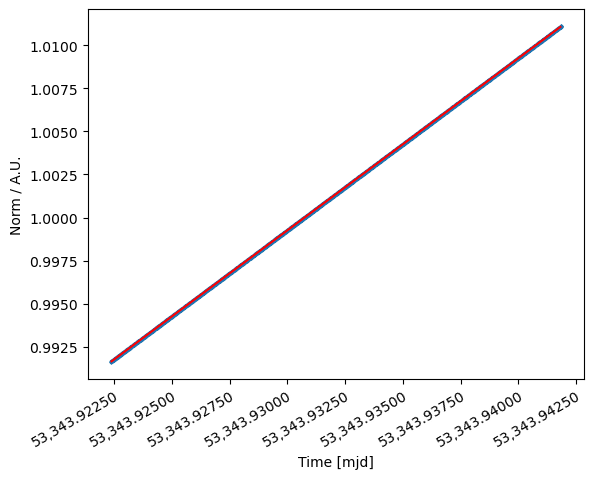

In [11]:
tmodel = LinearTemporalModel(alpha=1, beta=1/u.d, t_ref=53343.93*u.d)

tmodel.plot(dataset.gti.time_intervals[0], time_format='mjd', color='red', n_points=200)
plt.scatter(obs1.events.time.mjd, tmodel(obs1.events.time), s=2)


In [12]:
model_gauss.temporal_model=tmodel

In [63]:
# Set up a test instance of the unbinned Evaluator
test=UnbinnedEvaluator(model_gauss,events=obs1.events, mask=dataset.mask_safe, spatialbs=0.02*u.deg, use_cache=False, gti=dataset.gti)
test2=UnbinnedEvaluator(model_gauss2,events=obs1.events, mask=dataset.mask_safe, spatialbs=0.02*u.deg, use_cache=False, gti=dataset.gti)
# test.mask = dataset.mask_safe

# test._init_geom(exposure=dataset.exposure)
### for a proper comparison set the default value for the psf oversampling
### factor in 'update' to 1
test.update(obs1.events,dataset.exposure,dataset.psf,dataset.edisp, dataset.mask_safe)
test2.update(obs1.events,dataset.exposure,dataset.psf,dataset.edisp, dataset.mask_safe)

/home/hpc/caph/mppi086h/gammapy-unbinned-analysis/EventDataset/utils.py:330: GammapyDeprecationWarning: The apply_edisp function is deprecated and may be removed in a future version.
        Use gammapy.datasets.apply_edisp instead.
  acc_cube = psf_kernel.psf_kernel_map.quantity * mask2.apply_edisp(edisp_kernelT).data
/home/hpc/caph/mppi086h/gammapy-unbinned-analysis/EventDataset/utils.py:330: GammapyDeprecationWarning: The apply_edisp function is deprecated and may be removed in a future version.
        Use gammapy.datasets.apply_edisp instead.
  acc_cube = psf_kernel.psf_kernel_map.quantity * mask2.apply_edisp(edisp_kernelT).data


In [91]:
model_gauss.temporal_model.alpha.value = 2.

In [92]:
test.temporal_model.integral(test.gti.time_start, test.gti.time_stop)

<Quantity [2.00135995]>

In [93]:
res2, tot2 = test2.compute_npred()
res1, tot1 = test.compute_npred()
print(f"Map: {tot1:.6f} total counts")
print(f"Spec: {tot2:.6f} total counts")

Map: 301.074810 total counts
Spec: 150.435112 total counts


2.0014465682659752 2.0010291374528606


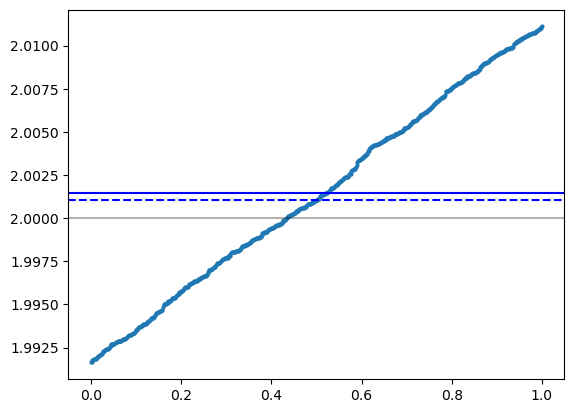

In [99]:
ratio_res = res1/res2
plt.scatter(np.linspace(0,1,len(ratio_res)), ratio_res, s=4)
plt.axhline(model_gauss.temporal_model.alpha.value, c='k', alpha=0.3)
plt.axhline(np.mean(ratio_res), c='b')
plt.axhline(np.median(ratio_res), c='b', ls='--')
print(np.mean(ratio_res), np.median(ratio_res))

The problem is that once the model has a temporal model the evaluation and integra_geom methods require GTIs. The model value is then scaled with the np.sum(integral) over the temporal model, so a simple scalar which is not what we need.

So we need to somehow split the model and the temporal model during evaluation but we also need to keep the model instance intact so it recieves the updated parameters correctly.